Importação das bibliotecas:

In [27]:
import matplotlib.pyplot as plt
import random
from math import sqrt, floor
from itertools import combinations

Aqui estão presentes as importtações das bibliotecas necessárias para rodar funções presentes no código.

Função para ler o arquivo TSP

In [28]:
def ler_arquivo_tsp(nome_arquivo):
    coordinates = []
    lendo_coordenadas = False
    with open(nome_arquivo, 'r') as arquivo:
        for linha in arquivo:
            if lendo_coordenadas:
                if "EOF" in linha:
                    break
                partes = linha.strip().split()
                x = float(partes[1])
                y = float(partes[2])
                coordinates.append((x, y))
            elif "NODE_COORD_SECTION" in linha:
                lendo_coordenadas = True
    return coordinates

Aqui há a função que encontra o arquivo TSP (que deve estar na mesma pasta que o arquivo em jupyter) e lê o mesmo, retornando as coordenadas que serão utilizadas durante a otimização do problema do caixeiro viajante. 

Definição das Constantes:

In [29]:
GENERATION_COUNT = 500
POPULATION_COUNT = 300
MUTATION_PROBABILITY = 0.7
ITERATION_COUNT = 3
ELITE_COUNT = 30

Aqui há a definição das principais variáveis do código, em que:
- Os valores da geração e população estão altos pois os resultados obtidos em testes menores não foram tão satisfatórios. Além disso, a solução caiu em ótimos locais, ficando presa em resultados dentro de um desvio;
- A mutação definida está de acordo com a pedida pelo professor em sala de aula na atividade de algoritmo genético anterior;
- O número de iterações corresponde ao número de rodadas solicitadas;
- A fim de evitar cair em ótimos locais, encontrou-se a variável "elite", em que seleciona x melhores resultados dentro da população e passa essa "genética" para as próximas gerações (como se fossem dominantes). O valor é definido de acordo com o número escolhido para a população, correspondendo a 10% dela.

Defininição do Caminho (Classe "Path")

In [30]:
class Path:
    def __init__(self, sequence):
        self.sequence = sequence
        self.distance = 0
        self.fitness = 0

    def __repr__(self):
        return "{ " + f"Caminho: {self.sequence}, Fitness: {self.fitness}" + " }"

Se trata a definição da classe "Path", responsável por representar qual o caminho o caixeiro viajante irá seguir. Ela faz isso através do armazenamento da sequência que será seguida, da distância entre os pontos e da fitness, que representa o quão bom é a rota selecionada.

Função sobre Inicialização:

In [31]:
def initialization(cities, populationCount):
    population = []
    for _ in range(populationCount):
        newPath = cities[:]
        random.shuffle(newPath)
        population.append(Path(newPath))
    return population

Essa função é responsável por iniciar a população do algoritmo genético, em que cria os caminhos de forma aleatória. 

Função para cálculo da distância:

In [32]:
def calculateDistance(path, coordinates):
    total = 0
    for i in range(len(path.sequence)):
        if i == len(path.sequence) - 1:
            distance = sqrt((coordinates[path.sequence[0]][0] - coordinates[path.sequence[i]][0])**2 + (
                coordinates[path.sequence[0]][1] - coordinates[path.sequence[i]][1])**2)
            total += distance
        else:
            distance = sqrt((coordinates[path.sequence[i+1]][0] - coordinates[path.sequence[i]][0])**2 + (
                coordinates[path.sequence[i+1]][1] - coordinates[path.sequence[i]][1])**2)
            total += distance
    path.distance = total
    return total

Essa função é responsável por calcular a distância total de uma determinada rota, fazendo o uso da distância euclidiana.

Função para cálculo da fitness:

In [33]:
def calculateFitness(population, coordinates):
    totalFitness = 0
    for path in population:
        distance = calculateDistance(path, coordinates)
        totalFitness += 1 / distance
        path.fitness = 1 / distance
    for path in population:
        path.fitness /= totalFitness
    return sorted(population, key=lambda x: x.fitness, reverse=True)

Essa função é responsável por encontrar a aptidão de cada caminho, ou seja, definir o quão bom ele é (assim, garante que caminhos mais curtos sejam melhores). Também serve para ordenar o caminho da população.

Função de seleção:

In [34]:
def tournamentSelection(population, tournament_size=5):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key=lambda x: x.fitness)

O método de seleção utilizado se trata da do Torneio, em que é selecionado um número de indivíduos da população (nesse caso, 5) de forma aleatória e seleciona o melhor deles para ser um dos pais da próxima geração.  

Função de Crossover:

In [35]:
def crossOver(population):
    father = tournamentSelection(population)
    mother = tournamentSelection(population)
    while mother == father:
        mother = tournamentSelection(population)
    startIndex = random.randint(0, len(mother.sequence) - 2)
    endIndex = random.randint(startIndex + 1, len(mother.sequence) - 1)
    childSequence = [None] * len(population[0].sequence)
    for i in range(startIndex, endIndex + 1):
        childSequence[i] = mother.sequence[i]
    for i in range(len(childSequence)):
        if childSequence[i] is None:
            for j in range(0, len(childSequence)):
                if father.sequence[j] not in childSequence:
                    childSequence[i] = father.sequence[j]
                    break
    return Path(childSequence)


O crossover realiza o cruzamento entre dois caminhos selecionados e cria um novo caminho para o filho, obtendo uma performance melhor por "herdar" as características dos pais.

Função de Mutação:

In [36]:
def mutation(path):
    firstIndex = random.randint(0, len(path.sequence) - 1)
    secondIndex = random.randint(0, len(path.sequence) - 1)
    while secondIndex == firstIndex:
        secondIndex = random.randint(0, len(path.sequence) - 1)
    probability = random.random()
    if probability < MUTATION_PROBABILITY:
        temp = path.sequence[firstIndex]
        path.sequence[firstIndex] = path.sequence[secondIndex]
        path.sequence[secondIndex] = temp
    return path

A mutação serve para garantir que o código tenha diversidade, alterando aleatoriamente alguns valores durante o cruzamento. Isso ajuda a evitar que a solução caia em ótimos locais. 

Algoritmo Genético:

In [37]:
def geneticAlgorithm(cities, populationCount, generationCount, coordinates):
    population = initialization(cities, populationCount)
    best_paths = []
    best_fitness_values = []

    for i in range(1, generationCount + 1):
        population = calculateFitness(population, coordinates)
        best = population[0]
        best_paths.append(best)
        best_fitness_values.append(best.fitness)

        print(f"{i}° Geração: {best.fitness}, Distância: {round(best.distance, 2)} km")

        newGeneration = []
        elites = sorted(population, key=lambda x: x.fitness, reverse=True)[:ELITE_COUNT]
        newGeneration.extend(elites)
    
        for _ in range(populationCount - ELITE_COUNT):
            child = crossOver(population)
            newGeneration.append(mutation(child))
        population = newGeneration

    return best_paths[-1]


Se trata do algoritmo genético em si, visando solucionar o problema do caixeiro viajante. 

Função para plotar a melhor rota:

In [38]:
def plot_best_route(best_routes, coordinates):
    for i, route in enumerate(best_routes):
        x = [coordinates[city][0] for city in route]
        y = [coordinates[city][1] for city in route]
        plt.figure(i)
        plt.plot(x, y, 'bo-')
        plt.title(f'Melhor rota da {i+1}° Iteração')
        plt.show()

Aqui é definida a função para plotar o gráfico da melhor rota encontrada por cada iteração (rodada).

Código Principal:


 1° Iteração:
1° Geração: 0.0037166556594552015, Distância: 4156.61 km


2° Geração: 0.0037979341029132987, Distância: 3895.09 km
3° Geração: 0.0038899566014620073, Distância: 3664.38 km
4° Geração: 0.003891253126643414, Distância: 3561.8 km
5° Geração: 0.003832834822686535, Distância: 3527.35 km
6° Geração: 0.00376429300972514, Distância: 3493.02 km
7° Geração: 0.0036762919191187906, Distância: 3514.34 km
8° Geração: 0.003724538884366262, Distância: 3417.61 km
9° Geração: 0.003717050394415527, Distância: 3355.1 km
10° Geração: 0.003661463587499648, Distância: 3354.88 km
11° Geração: 0.0036266703937599155, Distância: 3342.12 km
12° Geração: 0.0036347198831594503, Distância: 3291.85 km
13° Geração: 0.0036320248234179373, Distância: 3276.95 km
14° Geração: 0.0036420475900334763, Distância: 3235.33 km
15° Geração: 0.0036642099392487286, Distância: 3207.78 km
16° Geração: 0.003740784685340524, Distância: 3119.07 km
17° Geração: 0.0037433981337484496, Distância: 3082.1 km
18° Geração: 0.003741399843327525, Distância: 3049.47 km
19° Geração: 0.003707327994349072,

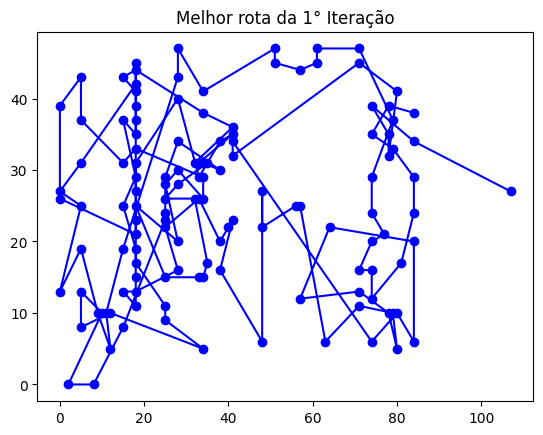

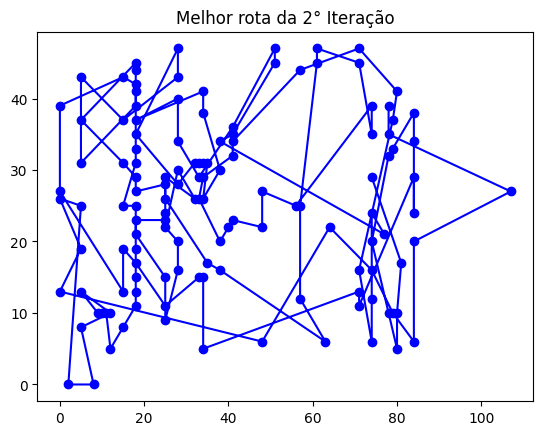

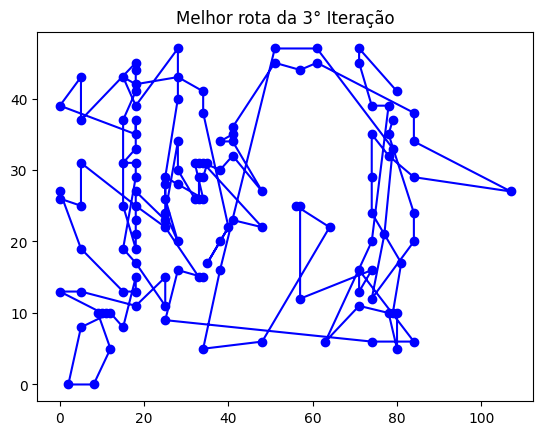

In [39]:
if __name__ == "__main__":
    nome_arquivo = 'xqf131.tsp'
    coordinates = ler_arquivo_tsp(nome_arquivo)
    cities = list(range(len(coordinates)))
    fitness_results = []
    distance_results = [] 
    best_routes = []

    for iteration in range(1, ITERATION_COUNT + 1):
        print(f"\n {iteration}° Iteração:")
        best_paths = []
        best_fitness_values = []
        best_distance_values = [] 
        population = initialization(cities, POPULATION_COUNT)

        for i in range(1, GENERATION_COUNT + 1):
            population = calculateFitness(population, coordinates)
            best = population[0]
            best_paths.append(best)
            best_fitness_values.append(best.fitness)
            best_distance_values.append(best.distance) 

            print(f"{i}° Geração: {best.fitness}, Distância: {round(best.distance, 2)} km")

            newGeneration = []
            for _ in range(POPULATION_COUNT):
                child = crossOver(population)
                newGeneration.append(mutation(child))
            population = newGeneration

        fitness_results.append(best_fitness_values)
        distance_results.append(best_distance_values) 
        best_routes.append(best_paths[-1].sequence)

        best_iteration = max(best_paths, key=lambda x: x.fitness)
        print(f"Melhor caminho na {iteration}° Iteração: {best_iteration.sequence}, Fitness: {best_iteration.fitness}")

    plot_best_route(best_routes, coordinates)

Essa é a parte  que executa o código em si, utilizando funções e classes definidas anteriormente. Logo, é através dela em que o problema é soluciona, retornando o resultado da fitness para cada geração dentro de cada população e posteriormente o gráfico da melhor rota encontrada.

Plotar Gráficos:

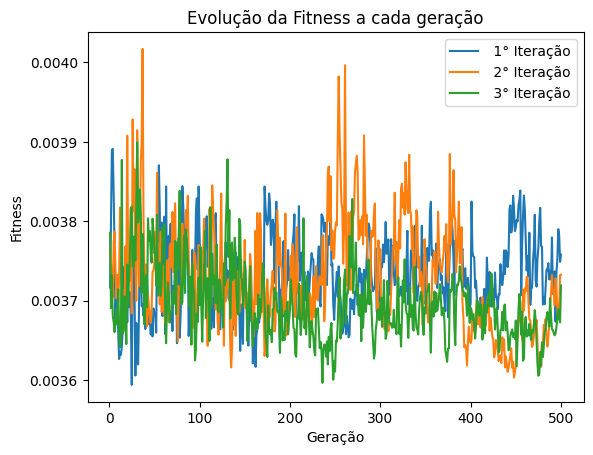

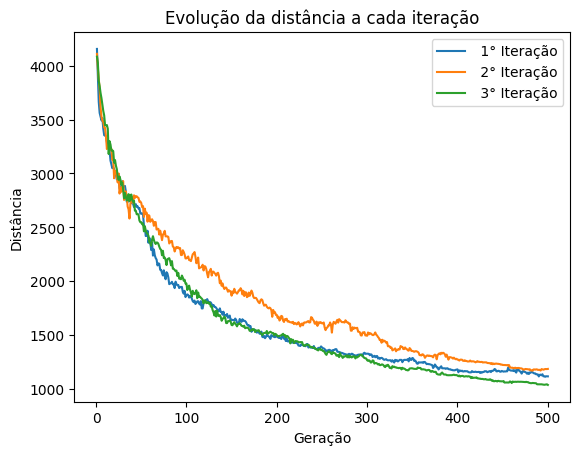

In [40]:
generations = list(range(1, GENERATION_COUNT + 1))
for iteration, fitness_values in enumerate(fitness_results, start=1):
    plt.plot(generations, fitness_values, label=f" {iteration}° Iteração")

plt.xlabel("Geração")
plt.ylabel("Fitness")
plt.title("Evolução da Fitness a cada geração")
plt.legend()
plt.show()

generations = list(range(1, GENERATION_COUNT + 1))
for iteration, distance_values in enumerate(distance_results, start=1):
    plt.plot(generations, distance_values, label=f" {iteration}° Iteração")

plt.xlabel("Geração")
plt.ylabel("Distância")
plt.title("Evolução da distância a cada iteração")
plt.legend()
plt.show()


Aqui são plotados os gráficos comparativos dos resultados encontradas em cada iteração, mostrando a evolução da fitness e da distância de cada rodada. Pode-se perceber que gráficos possuem a mesma silhueta, decaindo inicialmente até ficar mais constante na medida que as gerações vão passando. Entretanto, nota-se também que o melhor resultado não necessáriamente é o resultado da ultima geração, ou seja, caso tivessem mais gerações, pode ser que a solução seja ainda melhor. 